In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import umap.umap_ as umap

from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    silhouette_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from scipy.spatial.distance import cdist


In [2]:
feat_path  = "/nmhs2/prema/imageprocessing/imagenet-autoencoder/results/features/features.pth"
label_path = "/nmhs2/prema/imageprocessing/imagenet-autoencoder/results/features/labels.pth"

X = torch.load(feat_path).cpu().numpy()
y_true = torch.load(label_path).cpu().numpy()

# ---- REQUIRED FIX (sklearn expects 2D) ----
X = X.reshape(X.shape[0], -1)

print("Feature shape after flattening:", X.shape)


Feature shape after flattening: (8199, 25088)


In [10]:
def reduce_dimensionality(X, method, n_components):
    if method == "pca":
        return PCA(n_components=n_components, random_state=42).fit_transform(X)

    if method == "tsne":
        return TSNE(
        n_components=n_components,
        perplexity=30,
        random_state=42,
        method="exact"   # 👈 allows n_components > 3
    ).fit_transform(X)

    if method == "umap":
        return umap.UMAP(
            n_components=n_components,
            random_state=42
        ).fit_transform(X)

    raise ValueError("Unknown dimensionality reduction method")


In [11]:
def cluster_data(X, method, n_clusters=2):
    if method == "kmeans":
        return KMeans(n_clusters=n_clusters, random_state=42).fit_predict(X)

    if method == "gmm":
        return GaussianMixture(n_components=n_clusters, random_state=42).fit_predict(X)

    raise ValueError("Unknown clustering method")


In [12]:
def compute_icc(X, labels):
    icc = 0
    for c in np.unique(labels):
        pts = X[labels == c]
        center = pts.mean(axis=0)
        icc += np.mean(cdist(pts, center.reshape(1, -1)))
    return icc / len(np.unique(labels))


In [13]:
def align_labels(y_true, y_pred):
    acc1 = accuracy_score(y_true, y_pred)
    acc2 = accuracy_score(y_true, 1 - y_pred)
    return y_pred if acc1 >= acc2 else 1 - y_pred


In [14]:
def plot_2d(X, labels, title):
    plt.figure(figsize=(4, 4))
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=10)
    plt.title(title)
    plt.tight_layout()
    plt.show()



Running PCA with 2 components
  KMEANS → ARI=-0.080, NMI=0.105, ACC=0.566


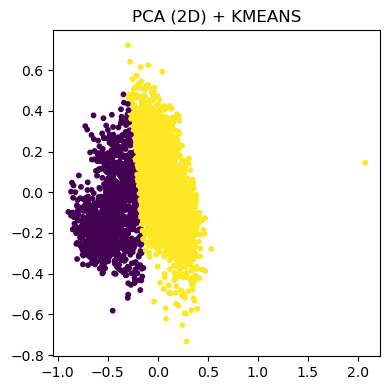

  GMM → ARI=-0.078, NMI=0.096, ACC=0.557


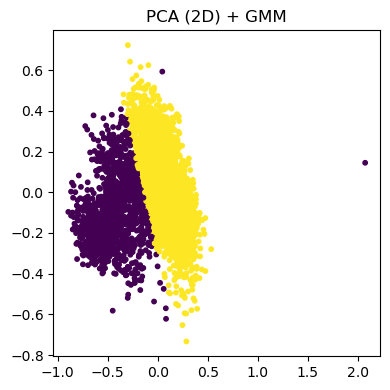


Running PCA with 4 components
  KMEANS → ARI=-0.081, NMI=0.108, ACC=0.565


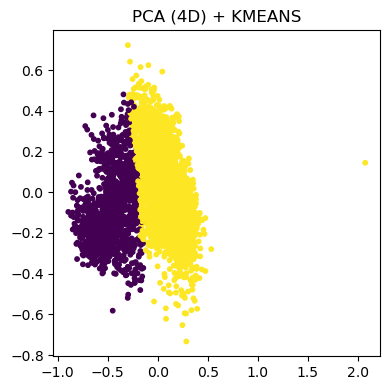

  GMM → ARI=-0.069, NMI=0.116, ACC=0.519


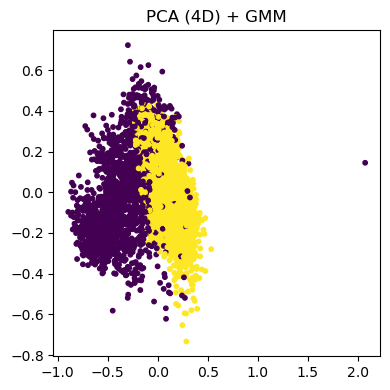


Running TSNE with 2 components
  KMEANS → ARI=-0.001, NMI=0.047, ACC=0.550


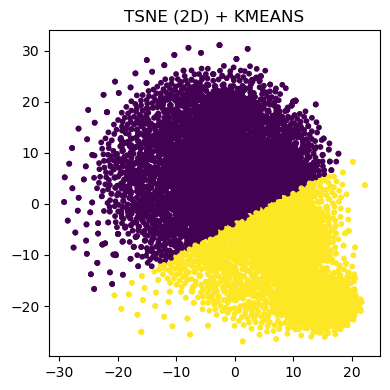

  GMM → ARI=-0.055, NMI=0.090, ACC=0.504


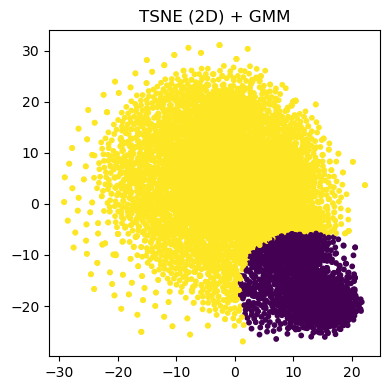


Running TSNE with 4 components
  KMEANS → ARI=0.032, NMI=0.037, ACC=0.589


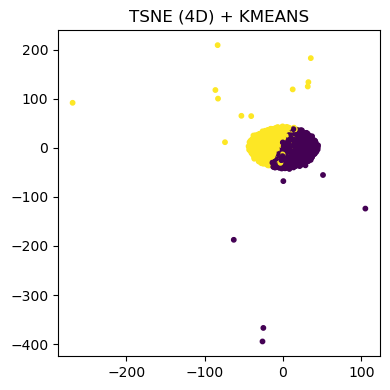

  GMM → ARI=-0.000, NMI=0.000, ACC=0.713


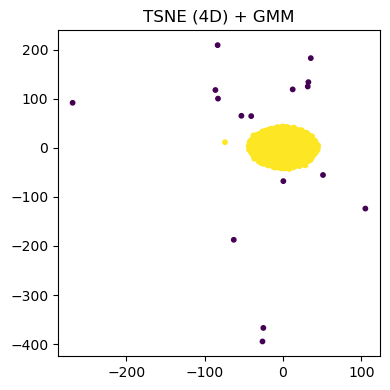


Running UMAP with 2 components


/home/prema/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  KMEANS → ARI=-0.015, NMI=0.033, ACC=0.520


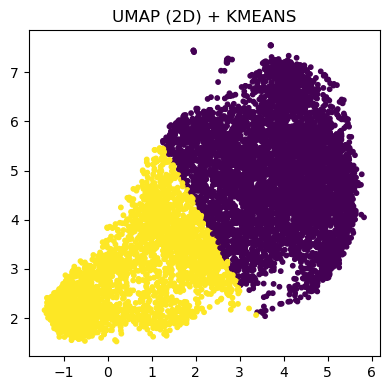

  GMM → ARI=-0.022, NMI=0.028, ACC=0.502


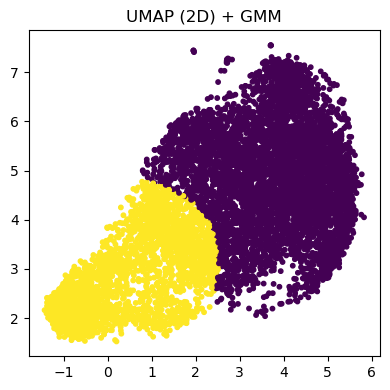


Running UMAP with 4 components


/home/prema/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  KMEANS → ARI=-0.038, NMI=0.040, ACC=0.513


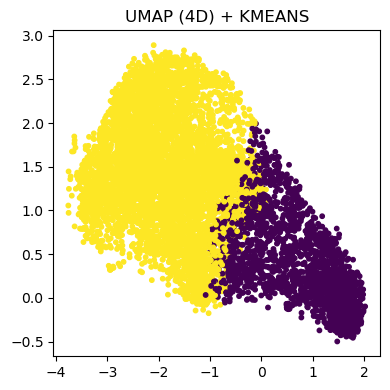

  GMM → ARI=-0.051, NMI=0.047, ACC=0.532


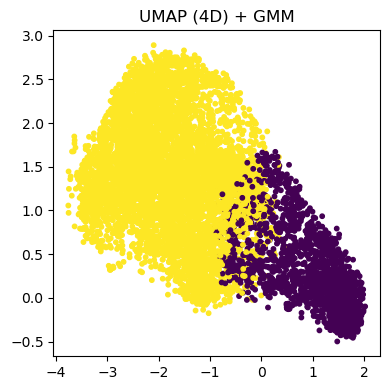

In [15]:
results = []

for red_method in ["pca", "tsne", "umap"]:
    for n_comp in [2, 4]:

        print(f"\nRunning {red_method.upper()} with {n_comp} components")
        X_red = reduce_dimensionality(X, red_method, n_comp)

        for clu_method in ["kmeans", "gmm"]:

            y_pred = cluster_data(X_red, clu_method)
            y_pred = align_labels(y_true, y_pred)

            ari = adjusted_rand_score(y_true, y_pred)
            nmi = normalized_mutual_info_score(y_true, y_pred)
            sil = silhouette_score(X_red, y_pred)
            icc = compute_icc(X_red, y_pred)

            acc  = accuracy_score(y_true, y_pred)
            prec = precision_score(y_true, y_pred)
            rec  = recall_score(y_true, y_pred)
            f1   = f1_score(y_true, y_pred)

            print(f"  {clu_method.upper()} → ARI={ari:.3f}, NMI={nmi:.3f}, ACC={acc:.3f}")

            results.append({
                "Dim_Reduction": red_method,
                "Components": n_comp,
                "Clustering": clu_method,
                "ARI": ari,
                "NMI": nmi,
                "Silhouette": sil,
                "ICC": icc,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1_score": f1
            })

            # Plot using first 2 dimensions
            plot_2d(
                X_red[:, :2],
                y_pred,
                f"{red_method.upper()} ({n_comp}D) + {clu_method.upper()}"
            )
